In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def nestedCV_RFE(path):
    data = pd.read_csv(path)
    X = data.drop(['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately'], axis=1)
    y = data['died_immediately']
    feature_names = X.columns

    X_train_total, X_test, y_train_total, y_test_total = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    

    scaler = MinMaxScaler()
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'RandomForestClassifier': RandomForestClassifier(),
        'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    trained_models = {'LogisticRegression': None,
        'RandomForestClassifier': None,
        'XGBClassifier': None
        }

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model_results = {}

    for model_name, model in models.items():
        outer_scores = []
        all_feature_sets = np.zeros((len(feature_names),))

        for train_index, test_index in outer_cv.split(X_train_total, y_train_total):
            X_train, X_test = X_train_total.iloc[train_index], X_train_total.iloc[test_index]
            y_train, y_test = y_train_total.iloc[train_index], y_train_total.iloc[test_index]
            X_train_scale = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train_scale, columns=X_train.columns, index=X_train.index)
            X_test_scale = scaler.transform(X_test)
            X_test = pd.DataFrame(X_test_scale, columns=X_test.columns, index=X_test.index)

            if model_name == 'XGBClassifier':
                weight = y_train.value_counts()[0] / y_train.value_counts()[1]
                model.set_params(scale_pos_weight=weight)

            rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
            rfecv.fit(X_train, y_train)

            all_feature_sets += rfecv.support_

            model.fit(X_train.loc[:, rfecv.support_], y_train)
            y_pred = model.predict(X_test.loc[:, rfecv.support_])
            score = accuracy_score(y_test, y_pred)
            outer_scores.append(score)

        feature_indices = all_feature_sets > (outer_cv.n_splits / 2)  
        selected_features = [feature_names[i] for i, selected in enumerate(feature_indices) if selected]
        model_results[model_name] = {
            'Average Accuracy': np.mean(outer_scores),
            'Selected Features': selected_features
        }
        trained_models[model_name] = model
        print(f'model: {model_name}\nAvg Acc: {model_results[model_name]["Average Accuracy"]}\nSelected Features: {model_results[model_name]["Selected Features"]}\nFeature number: {len(model_results[model_name]["Selected Features"])}')

    best_model = max(model_results, key=lambda x: model_results[x]['Average Accuracy'])
    best_model_results = model_results[best_model]

    print(f"Best Model: {best_model}, with Average Accuracy: {best_model_results['Average Accuracy']}")
    print("Selected Features:", best_model_results['Selected Features'])
    


Without comorbidity

In [3]:
nestedCV_RFE(r'F:\\STUDY\\python_code\\Pract_DA\\prepocess\\cleaned_data\\cleaned_data_allfill.csv')

model: LogisticRegression
Avg Acc: 0.8479591836734693
Selected Features: ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinus Brady', 'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 'hear_last_Comp Heart Block', 'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy', 'hear_last_V Paced']
Feature number: 49
model: RandomForestClassifier
Avg Acc: 0.8629159772016914
Selected Features: ['age', 'icu_duration_hour', 'glu_min', 'glu_avg', 'figglu_min', 'figg

With comro

In [4]:
nestedCV_RFE('F:\\STUDY\\python_code\\Pract_DA\\prepocess\\cleaned_data\\cleaned_data_allfill_withComro.csv')

model: LogisticRegression
Avg Acc: 0.8465986394557824
Selected Features: ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinus Brady', 'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy', 'hear_last_V Paced']
Feature number: 48
model: RandomForestClassifier
Avg Acc: 0.8602224673653245
Selected Features: ['age', 'icu_duration_hour', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_avg', 'pot_min', 'pot_max',

RFE用于xgb+ocsvm

OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
Model: LogiR, Recall: 0.8763, Accuracy: 0.6179
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
Model: RF, Recall: 0.8763, Accuracy: 0.6179
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
OCSVM Train finish
Model: XGB, Recall: 0.8763, Accuracy: 0.6179
Best Model: LogiR with Best Recall: 0.8763
{'OCSVM': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinu

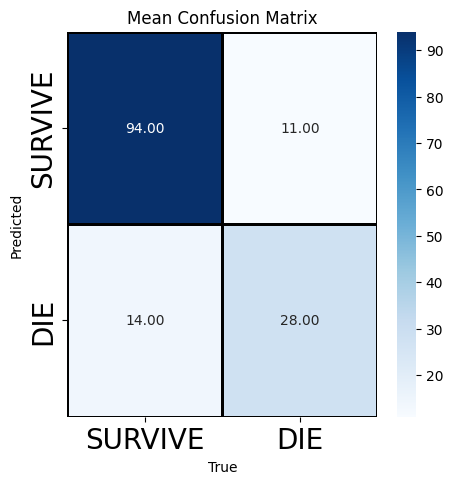

Class SURVIVE - Precision: 0.90, Recall: 0.87, F1 Score: 0.88, Support: 108.0
Class DEATH   - Precision: 0.67, Recall: 0.72, F1 Score: 0.69, Support: 39.0
Overall Accuracy: 0.8299


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


def train_stackXGB(X_train, y_train):
    np.random.seed(42)
    X_train_neg = X_train[y_train == 0]
    X_train_pos = X_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    group_size=int(X_train_neg.shape[0]/3 + X_train_pos.shape[0])
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    models = []
    predictions = []

    for train_idx, _ in skf.split(X_train_neg, y_train_neg):
        X_fold_neg = X_train_neg.iloc[train_idx]
        if len(X_fold_neg) < group_size:
            extra_idx = np.random.choice(X_fold_neg.index, size=group_size - len(X_fold_neg), replace=True)
            X_fold_neg = pd.concat([X_fold_neg, X_train_neg.loc[extra_idx]])

        X_fold = pd.concat([X_fold_neg, X_train_pos])
        y_fold = pd.concat([y_train_neg.loc[X_fold_neg.index], y_train_pos])
        num_neg = np.sum(y_fold == 0)
        num_pos = np.sum(y_fold == 1)
        scale_pos_weight = num_neg / num_pos
        model = xgb.XGBClassifier(#objective='binary:logistic', 
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  #reg_lambda = 5, 
                                  scale_pos_weight = scale_pos_weight
                                  #reg_alpha = 1
                                  )
        model.fit(X_fold, y_fold)
        models.append(model)

        pred = model.predict_proba(X_fold)[:, 1]
        predictions.append(pred)

    predictions = np.vstack(predictions).T

    
    lin_reg_xgb = LinearRegression()
    lin_reg_xgb.fit(predictions, y_fold)
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    stakxgb_pred = (stakxgb_pred > 0.5).astype(int)
    stakxgb_pred = stakxgb_pred.reshape(-1, 1)
    
    
    print('Stack XGB Train result')
    print(classification_report(y_fold, stakxgb_pred))
    cm = confusion_matrix(y_fold, stakxgb_pred)
    print(cm)
    
    return models, lin_reg_xgb 

def train_one_class_svm(X_train, y_train):
    svm_train_X = X_train[y_train == 0] 
    oc_svm = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7)
    oc_svm.fit(svm_train_X)
    print('OCSVM Train finish')
    
    return oc_svm

def combined_train(X_train, y_train, features):
    xgb_feature = features['XGB']
    xgbs, lin_reg_xgb = train_stackXGB(X_train[xgb_feature], y_train)
    xgb_predictions = []
    for model in xgbs:
        pred = model.predict_proba(X_train[xgb_feature])[:, 1] 
        xgb_predictions.append(pred)

    xgb_predictions = np.vstack(xgb_predictions).T
    stakxgb_pred = lin_reg_xgb.predict(xgb_predictions).reshape(-1, 1)
    #stakxgb_pred = (stakxgb_pred > 0.5).astype(int) 
    
    svm_feature = features['OCSVM']
    ocsvm = train_one_class_svm(X_train[svm_feature], y_train)
    svm_scores = ocsvm.decision_function(X_train[svm_feature])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)
    print(thresh)

    ocsvm_pred = normalized_scores.reshape(-1, 1)
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1).reshape(-1, 1)

    
    print(stakxgb_pred.shape)
    print(ocsvm_pred.shape)
    
    combined_predictions = np.hstack([stakxgb_pred, ocsvm_pred])


    final_lin_reg = LinearRegression()
    final_lin_reg.fit(combined_predictions, y_train)
    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    

    
    print('Final Train result')
    print(classification_report(y_train, final_pred))
    cm = confusion_matrix(y_train, final_pred)
    print(cm)

    return xgbs, lin_reg_xgb, ocsvm,final_lin_reg


def test_models(models, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features):
    print('Testing')
    xgb_feature = features['XGB']
    predictions = []
    for model in models:
        pred = model.predict_proba(X_test[xgb_feature])[:, 1] 
        predictions.append(pred)

    predictions = np.vstack(predictions).T
    stakxgb_pred = lin_reg_xgb.predict(predictions)
    
    svm_feature = features['OCSVM']
    svm_scores = ocsvm.decision_function(X_test[svm_feature])
    mean_val = svm_scores.mean()
    std_val = svm_scores.std()
    standardized_scores = (svm_scores - mean_val) / std_val
    min_val = standardized_scores.min()
    max_val = standardized_scores.max()
    normalized_scores = (standardized_scores - min_val) / (max_val - min_val)

    #   remains to be done, 
    #   the thresh calculated, which should be the best value, turns out is not good enough
    thresh = (0 - min_val) / (max_val - min_val)

    
    ocsvm_pred = normalized_scores
    #ocsvm_pred = np.where(normalized_scores > 0.45, 0,1)
    
    combined_predictions = np.hstack([stakxgb_pred.reshape(-1, 1), ocsvm_pred.reshape(-1, 1)])

    final_pred = final_lin_reg.predict(combined_predictions)
    final_pred = np.where(final_pred < 0.5, 0 , 1)
    
    return final_pred







data = pd.read_csv('F:\\STUDY\\python_code\\Pract_DA\\prepocess\\cleaned_data\\cleaned_data_allfill_withComro.csv')
X = data.drop(['subject_id', 'icustay_id', 'hospital_expire_flag', 'expire_flag', 'died_immediately'], axis=1)
y = data['died_immediately']
feature_names = X.columns

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
  

############## 放在cv里面 ####################
#scaler = MinMaxScaler()
#X_train_total = scaler.fit_transform(X_train)
#X_train_total = pd.DataFrame(X_train_total, columns=X_train.columns, index=X_train.index)
#X_test_total = scaler.transform(X_test)
#X_test_total = pd.DataFrame(X_test_total, columns=X_test.columns, index=X_test.index)


models = {
    'OCSVM': OneClassSVM(nu=0.001, kernel="rbf", gamma=0.7),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

trained_models = {'OCSVM': None,
    'XGB': None
    }

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_results = {}


for train_index, test_index in outer_cv.split(X_train_total, y_train_total):
    X_train, X_test = X_train_total.iloc[train_index], X_train_total.iloc[test_index]
    y_train, y_test = y_train_total.iloc[train_index], y_train_total.iloc[test_index]
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scale, columns=X_train.columns, index=X_train.index)
    X_test_scale = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scale, columns=X_test.columns, index=X_test.index)
    accuracies = []  
    all_cm = [] 
    features= {}
    for model_name, model in models.items():   
        if model_name == 'XGB':
            outer_scores = []
            all_feature_sets = np.zeros((len(feature_names),)) 
            inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            for train_index, test_index in skf.split(X_train[feature_], y_train):
                X_train_sub = X_train.iloc[train_index]
                X_test_sub = X_train.iloc[test_index]
                y_train_sub = y_train.iloc[train_index]
                y_test_sub = y_train.iloc[test_index]
                weight = y_train_sub.value_counts()[0] / y_train.value_counts()[1]
                model.set_params(scale_pos_weight=weight)

                rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
                rfecv.fit(X_train, y_train)

                all_feature_sets += rfecv.support_

                model.fit(X_train.loc[:, rfecv.support_], y_train)
                y_pred = model.predict(X_test.loc[:, rfecv.support_])
                score = accuracy_score(y_test, y_pred)
                outer_scores.append(score)

            feature_indices = all_feature_sets > (inner_cv.n_splits / 2)  
            selected_features = [feature_names[i] for i, selected in enumerate(feature_indices) if selected]

            model_results[model_name] = {
                'Average Accuracy': np.mean(outer_scores),
                'Selected Features': selected_features
            }
            features[model_name] = selected_features
            #trained_models[model_name] = model
            #print(f'model: {model_name}\nAvg Acc: {model_results[model_name]["Average Accuracy"]}\nSelected Features: {model_results[model_name]["Selected Features"]}\nFeature number: {len(model_results[model_name]["Selected Features"])}')

        elif model_name == "OCSVM":
            modelSelectedFeatures = {
                'LogiR': ['age', 'icu_times', 'icu_times_total', 'icu_times_sepsis', 'icu_times_total_sepsis', 'glu_min', 'glu_avg', 
                          'figglu_min', 'figglu_max', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 'hem_min', 'hem_max', 'hem_avg', 
                          'bun_min', 'bun_avg', 'cre_avg', 'hemo_max', 'car_min', 'car_max', 'car_avg', 'pla_min', 'wbc_min', 'hea_min',
                          'hea_max', 'hea_avg', 'mag_min', 'res_min', 'res_avg', 'spo_min', 'spo_max', 'spo_avg', 'spo_alarms', 'temp_min',
                          'temp_max', 'hear_mode_1st Deg AV Block', 'hear_mode_Atrial Flutter', 'hear_mode_Sinus Brady', 
                          'hear_mode_Sinus Tachy', 'hear_mode_V Paced', 'hear_last_Asystole', 'hear_last_Atrial Fib', 
                          'hear_last_Normal Sinus', 'hear_last_Other/Remarks', 'hear_last_Supravent Tachy', 'hear_last_V Paced'],
                'RF': ['age', 'icu_duration_hour', 'glu_min', 'glu_avg', 'figglu_min', 'figglu_avg', 'pot_min', 'pot_max', 'pot_avg', 
                       'sod_min', 'sod_avg', 'hem_min', 'hem_max', 'hem_avg', 'chl_min', 'chl_max', 'chl_avg', 'bun_min', 'bun_max', 
                       'bun_avg', 'hemo_min', 'hemo_max', 'hemo_avg', 'car_min', 'car_max', 'car_avg', 'rbc_min', 'pla_min', 'pla_max', 
                       'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 'hea_min', 'hea_max', 'hea_avg', 'mag_min', 'mag_avg', 'res_min', 
                       'res_max', 'res_avg', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 'temp_max', 'temp_avg', 'hear_last_Asystole',
                       'hear_last_Normal Sinus'],
                "XGB": ['age', 'gender', 'icu_duration_hour', 'icu_times', 'icu_times_total', 'glu_min', 'glu_max', 'glu_avg', 
                        'figglu_min', 'figglu_max', 'figglu_avg', 'pot_avg', 'sod_min', 'sod_max', 'sod_avg', 'hem_max', 'hem_avg', 
                        'chl_max', 'chl_avg', 'bun_min', 'bun_max', 'bun_avg', 'cre_min', 'cre_max', 'cre_avg', 'hemo_min', 'car_min', 
                        'car_max', 'car_avg', 'rbc_min', 'rbc_max', 'pla_min', 'pla_max', 'pla_avg', 'wbc_min', 'wbc_max', 'wbc_avg', 
                        'hea_min', 'hea_max', 'hea_avg', 'mag_max', 'res_min', 'res_max', 'spo_min', 'spo_avg', 'spo_alarms', 'temp_min', 
                        'temp_max', 'temp_avg', 'hear_last_1st Deg AV Block', 'hear_last_Normal Sinus']    
            }
            skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
            best_model = None
            best_score = 0
            model_performance = {}
            for model_name_, feature_ in modelSelectedFeatures.items():
                recall_scores = []
                accuracy_scores = []

                for train_index, test_index in skf.split(X_train[feature_], y_train):
                    X_train_sub = X_train.iloc[train_index]
                    X_test_sub = X_train.iloc[test_index]
                    y_train_sub = y_train.iloc[train_index]
                    y_test_sub = y_train.iloc[test_index]
                    
                    ocsvm = train_one_class_svm(X_train_sub,y_train_sub)
                    y_pred = ocsvm.predict(X_test_sub)
                    y_pred = np.where(y_pred == 1, 0, 1)
                    
                    recall = recall_score(y_test_sub, y_pred, pos_label=1)
                    accuracy = accuracy_score(y_test_sub, y_pred)
                    recall_scores.append(recall)
                    accuracy_scores.append(accuracy)
                    avg_recall = np.mean(recall_scores)
                avg_accuracy = np.mean(accuracy_scores)
                model_performance[model_name_] = {'recall': avg_recall, 'accuracy': avg_accuracy}

                print(f"Model: {model_name_}, Recall: {avg_recall:.4f}, Accuracy: {avg_accuracy:.4f}")

                if avg_recall > best_score:
                    best_score = avg_recall
                    best_model = model_name_

            print(f"Best Model: {best_model} with Best Recall: {best_score:.4f}")
            features[model_name] = modelSelectedFeatures[best_model]
            
    print(features)    
    xgbs, lin_reg_xgb, ocsvm,final_lin_reg = combined_train(X_train, y_train, features)
    final_pred_class = test_models(xgbs, lin_reg_xgb, ocsvm, final_lin_reg, X_test, features)
    
    accuracy = accuracy_score(y_test, final_pred_class)
    cm = confusion_matrix(y_test, final_pred_class)
    
    accuracies.append(accuracy)
    all_cm.append(cm)

mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {mean_accuracy:.4f}")
mean_cm = np.mean(all_cm, axis=0)
plt.figure(figsize=(5,5))
sns.heatmap(mean_cm.T, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='.2f', xticklabels=['SURVIVE', 'DIE'], yticklabels=['SURVIVE', 'DIE'])
plt.title('Mean Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
TN, FP = mean_cm[0, 0], mean_cm[0, 1]
FN, TP = mean_cm[1, 0], mean_cm[1, 1]

precision_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0

recall_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0

f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

accuracy = (TP + TN) / (TP + TN + FP + FN)

support_0 = TN + FP
support_1 = TP + FN

print(f"Class SURVIVE - Precision: {precision_0:.2f}, Recall: {recall_0:.2f}, F1 Score: {f1_0:.2f}, Support: {support_0}")
print(f"Class DEATH   - Precision: {precision_1:.2f}, Recall: {recall_1:.2f}, F1 Score: {f1_1:.2f}, Support: {support_1}")
print(f"Overall Accuracy: {accuracy:.4f}")
    
    
